FORECASTING HIDRELÉTRICO - LightGBM + SHAP

[1/6] Feature Engineering...
Features criadas: 50 colunas

[2/6] Split Train/Test...
Train: 1139 amostras | Test: 285 amostras
Total de features: 47

[3/6] Treinando LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 49.3814	valid's rmse: 103.703
Early stopping, best iteration is:
[61]	train's rmse: 66.7628	valid's rmse: 102.771

[4/6] Avaliação do Modelo...

MÉTRICAS NO CONJUNTO DE TESTE:
MAE: 82.40 MW
RMSE: 102.77 MW
R²: 0.9188
MAPE: 4.47%

[5/6] Gerando Visualizações...


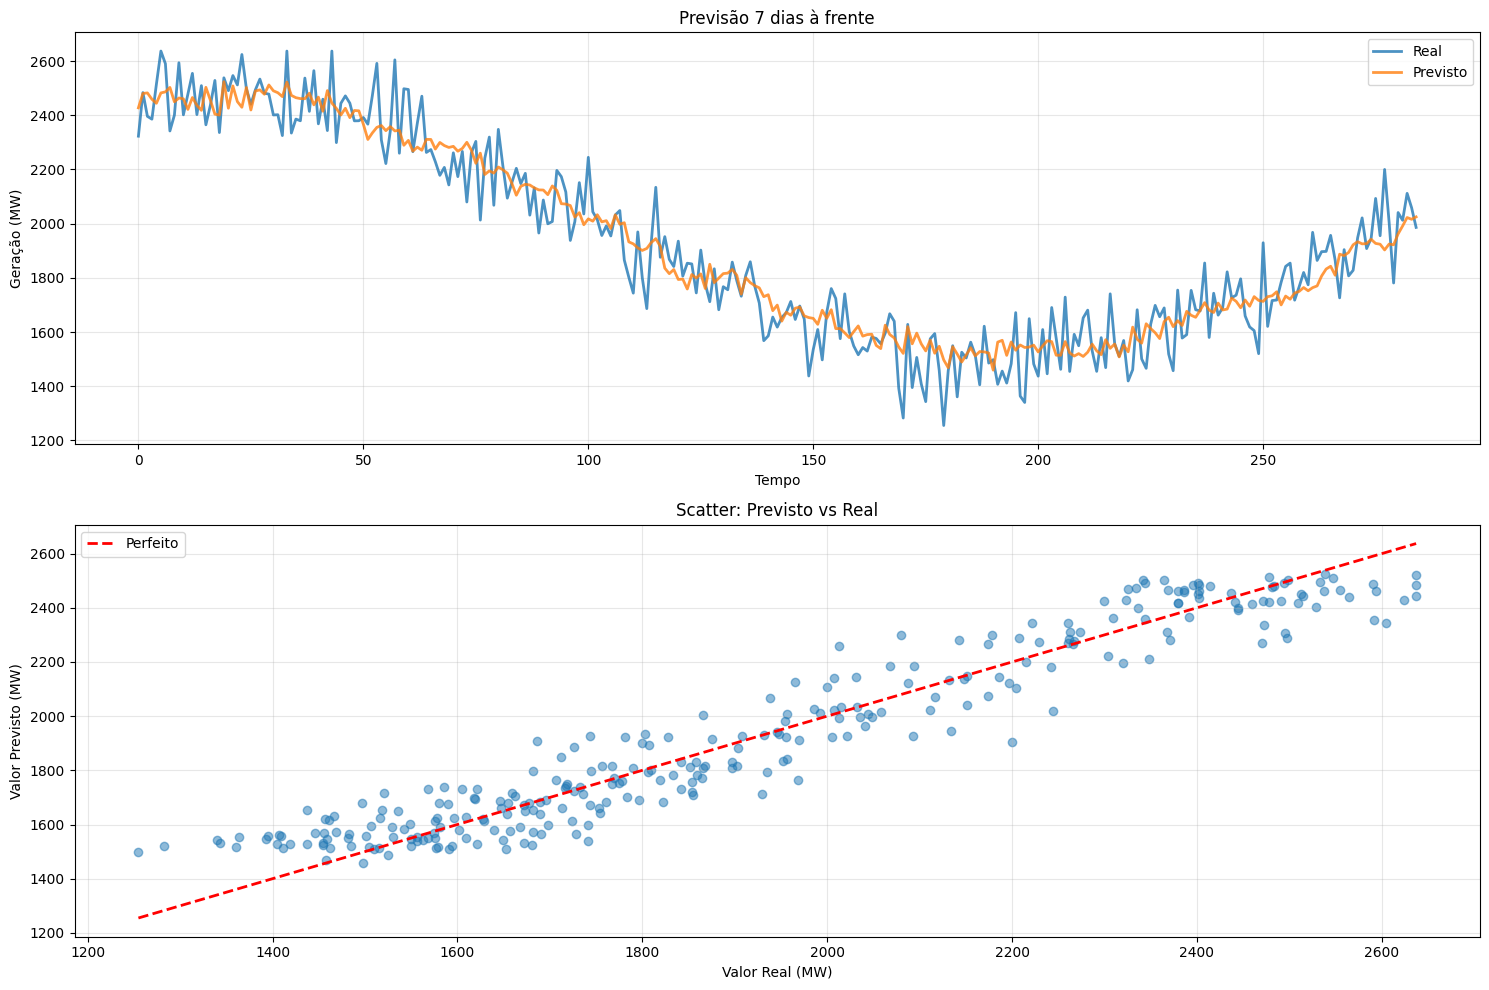

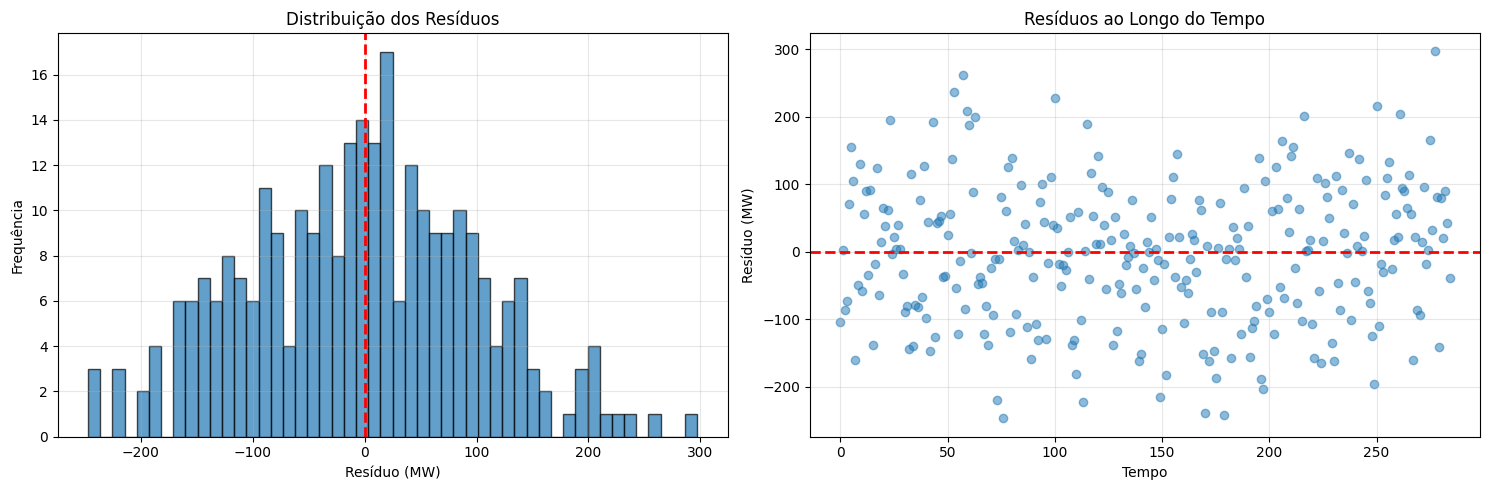


[6/6] Análise SHAP (Explicabilidade)...

Calculando valores SHAP...

1. SHAP Summary Plot - Visão Geral


/tmp/ipython-input-554779369.py:315: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test, X_test, max_display=max_display, show=False)


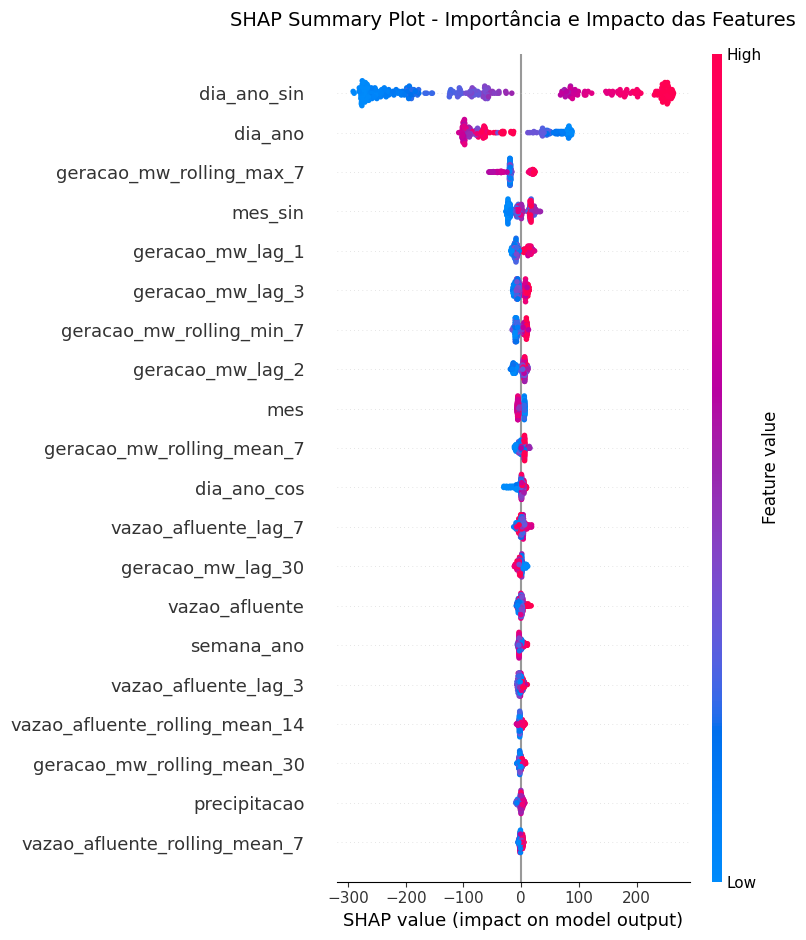


2. SHAP Bar Plot - Importância Média


/tmp/ipython-input-554779369.py:323: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test, X_test, plot_type="bar",


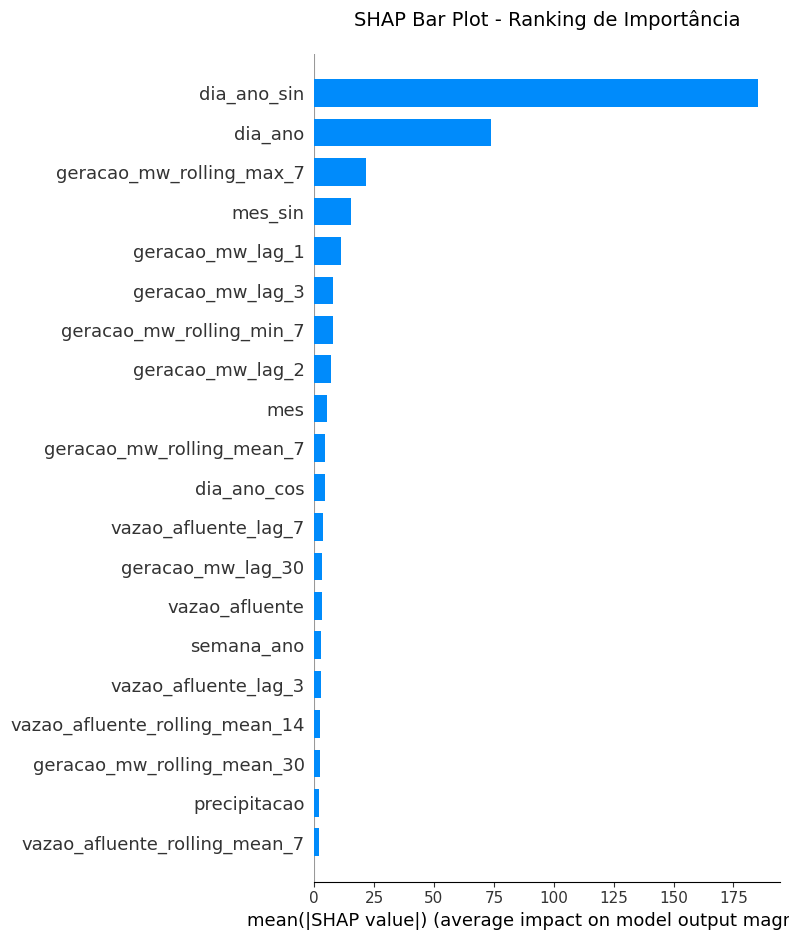


3. SHAP Dependence Plots - Top 4 Features


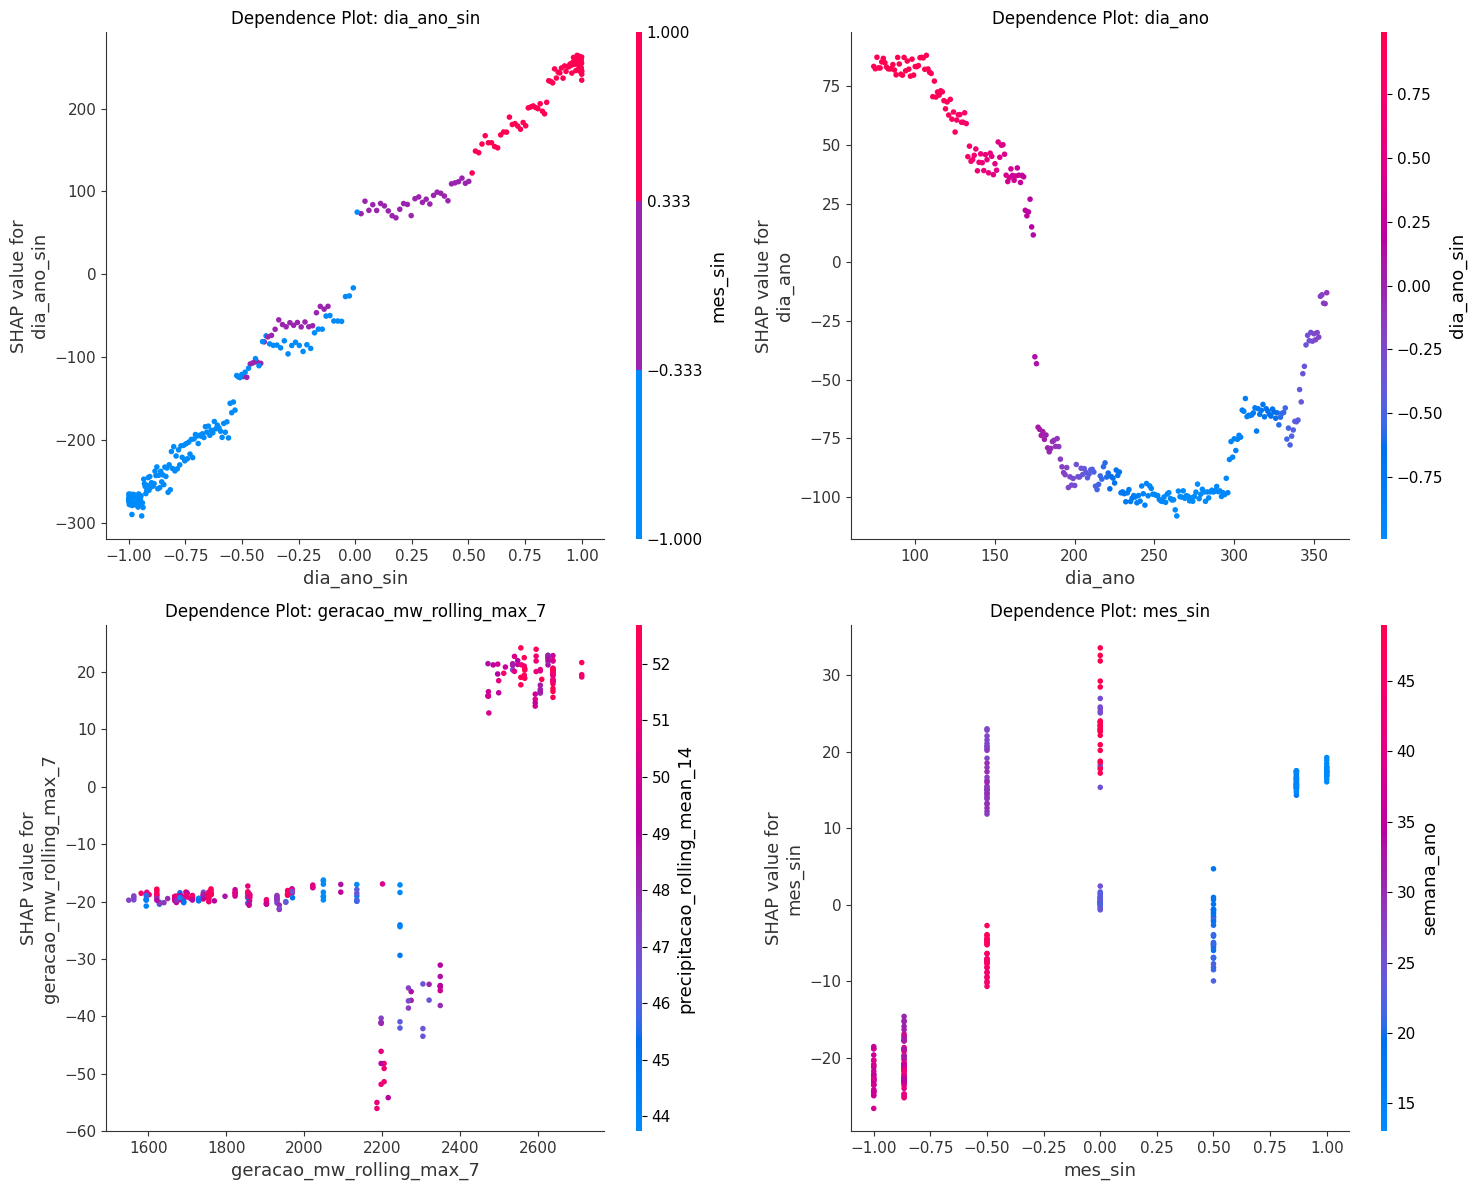


4. SHAP Waterfall Plot - Exemplo de Predição


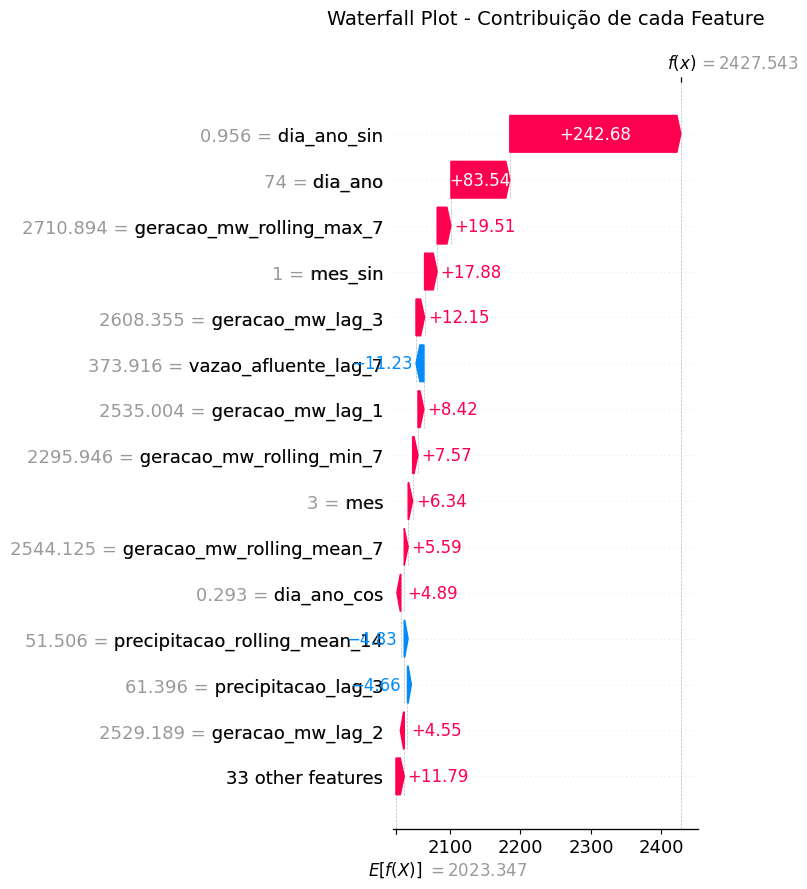


5. SHAP Force Plot


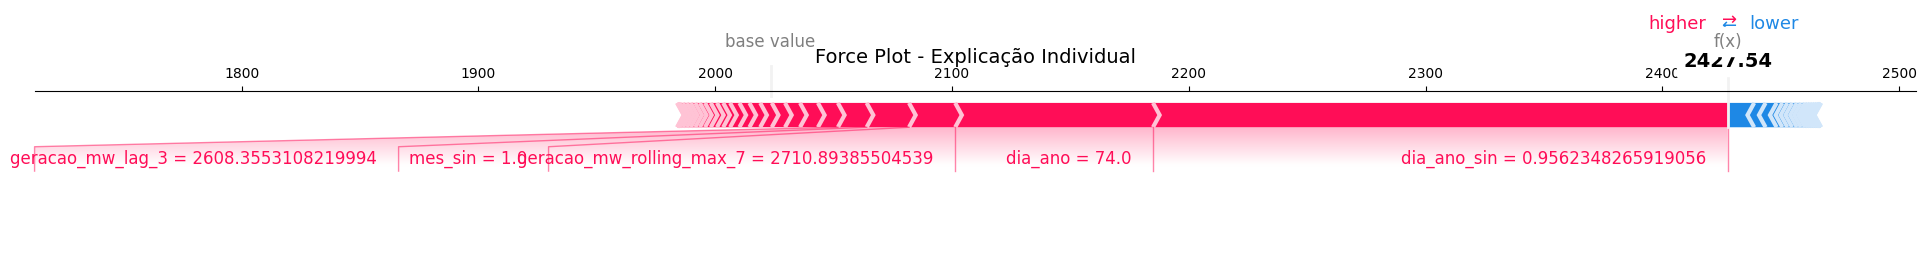

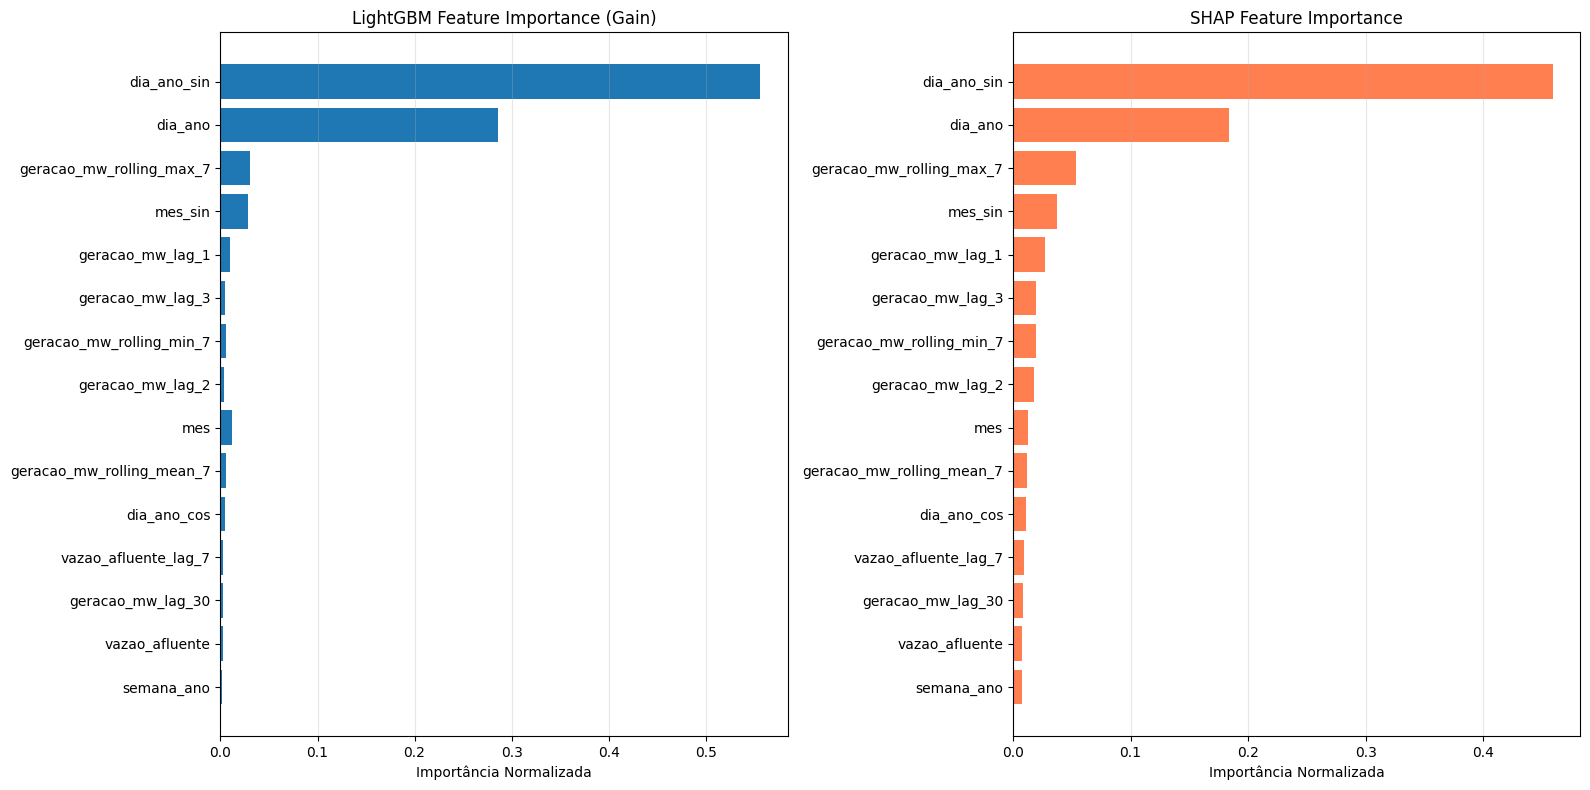


✓ Modelo salvo como 'modelo_lightgbm_hidro.txt'

PIPELINE CONCLUÍDO COM SUCESSO!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import shap

# ==========================================
# 1. FEATURE ENGINEERING
# ==========================================

def create_time_features(df, date_col='data'):
    """
    Cria features temporais a partir da data
    """
    df = df.copy()
    df['dia_semana'] = df[date_col].dt.dayofweek
    df['dia_mes'] = df[date_col].dt.day
    df['mes'] = df[date_col].dt.month
    df['trimestre'] = df[date_col].dt.quarter
    df['dia_ano'] = df[date_col].dt.dayofyear
    df['semana_ano'] = df[date_col].dt.isocalendar().week
    df['fim_semana'] = (df['dia_semana'] >= 5).astype(int)

    # Features cíclicas (importante para capturar sazonalidade)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['dia_ano_sin'] = np.sin(2 * np.pi * df['dia_ano'] / 365)
    df['dia_ano_cos'] = np.cos(2 * np.pi * df['dia_ano'] / 365)

    return df


def create_lag_features(df, target_col='geracao_mw', lags=[1, 2, 3, 7, 14, 30]):
    """
    Cria features de lag (valores passados)
    """
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df


def create_rolling_features(df, target_col='geracao_mw', windows=[7, 14, 30]):
    """
    Cria features de médias móveis e estatísticas
    """
    df = df.copy()
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    return df


def create_external_features(df, feature_cols):
    """
    Cria lags e rolling para variáveis externas (vazão, precipitação, etc)
    """
    df = df.copy()
    for col in feature_cols:
        # Lags para variáveis externas
        for lag in [1, 3, 7]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

        # Rolling para variáveis externas
        for window in [7, 14]:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()

    return df


def prepare_features(df, target_col='geracao_mw',
                    external_cols=['vazao_afluente', 'precipitacao', 'nivel_reservatorio'],
                    forecast_horizon=7):
    """
    Pipeline completo de feature engineering
    """
    df = df.copy()

    # Features temporais
    df = create_time_features(df)

    # Lags do target
    df = create_lag_features(df, target_col)

    # Rolling statistics
    df = create_rolling_features(df, target_col)

    # Features de variáveis externas
    if external_cols:
        df = create_external_features(df, external_cols)

    # Criar target para forecast_horizon dias à frente
    df[f'{target_col}_target'] = df[target_col].shift(-forecast_horizon)

    # Remover NaN criados pelos lags e rolling
    df = df.dropna()

    return df


# ==========================================
# 2. PREPARAÇÃO DOS DADOS
# ==========================================

def split_train_test(df, target_col='geracao_mw_target', test_size=0.2):
    """
    Split temporal dos dados
    """
    # Identificar features (todas exceto target e data)
    feature_cols = [col for col in df.columns if col not in [target_col, 'data', 'geracao_mw']]

    X = df[feature_cols]
    y = df[target_col]

    # Split temporal
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test, feature_cols


# ==========================================
# 3. MODELO LIGHTGBM
# ==========================================

def train_lightgbm(X_train, y_train, X_val, y_val, params=None):
    """
    Treina modelo LightGBM com validação
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'max_depth': -1,
            'min_child_samples': 20,
            'verbose': -1
        }

    # Criar datasets LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Treinar com early stopping
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    return model


def cross_validate_model(X, y, n_splits=5):
    """
    Cross-validation temporal
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = {'mae': [], 'rmse': [], 'r2': []}

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)

        cv_scores['mae'].append(mae)
        cv_scores['rmse'].append(rmse)
        cv_scores['r2'].append(r2)

        print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

    print("\n" + "="*50)
    print("RESULTADOS CROSS-VALIDATION:")
    print(f"MAE médio: {np.mean(cv_scores['mae']):.2f} ± {np.std(cv_scores['mae']):.2f}")
    print(f"RMSE médio: {np.mean(cv_scores['rmse']):.2f} ± {np.std(cv_scores['rmse']):.2f}")
    print(f"R² médio: {np.mean(cv_scores['r2']):.4f} ± {np.std(cv_scores['r2']):.4f}")

    return cv_scores


# ==========================================
# 4. AVALIAÇÃO
# ==========================================

def evaluate_model(model, X_test, y_test):
    """
    Avalia modelo e calcula métricas
    """
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print("\nMÉTRICAS NO CONJUNTO DE TESTE:")
    print(f"MAE: {mae:.2f} MW")
    print(f"RMSE: {rmse:.2f} MW")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return y_pred, {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}


def plot_predictions(y_true, y_pred, title="Previsão vs Real"):
    """
    Visualiza previsões vs valores reais
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Série temporal
    axes[0].plot(y_true.values, label='Real', linewidth=2, alpha=0.8)
    axes[0].plot(y_pred, label='Previsto', linewidth=2, alpha=0.8)
    axes[0].set_xlabel('Tempo')
    axes[0].set_ylabel('Geração (MW)')
    axes[0].set_title(title)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Scatter plot
    axes[1].scatter(y_true, y_pred, alpha=0.5)
    axes[1].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()],
                 'r--', linewidth=2, label='Perfeito')
    axes[1].set_xlabel('Valor Real (MW)')
    axes[1].set_ylabel('Valor Previsto (MW)')
    axes[1].set_title('Scatter: Previsto vs Real')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_residuals(y_true, y_pred):
    """
    Análise de resíduos
    """
    residuals = y_true.values - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Distribuição dos resíduos
    axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Resíduo (MW)')
    axes[0].set_ylabel('Frequência')
    axes[0].set_title('Distribuição dos Resíduos')
    axes[0].grid(True, alpha=0.3)

    # Resíduos ao longo do tempo
    axes[1].scatter(range(len(residuals)), residuals, alpha=0.5)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Tempo')
    axes[1].set_ylabel('Resíduo (MW)')
    axes[1].set_title('Resíduos ao Longo do Tempo')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import shap

# ==========================================
# ==========================================
# 5. ANÁLISE SHAP (EXPLICABILIDADE)
# ==========================================

def analyze_shap(model, X_train, X_test, feature_names, max_display=20):
    """
    Análise completa SHAP para explicabilidade
    """
    print("\nCalculando valores SHAP...")

    # Criar explainer
    explainer = shap.TreeExplainer(model)
    shap_values_train = explainer.shap_values(X_train)
    shap_values_test = explainer.shap_values(X_test)

    # 1. Summary Plot (importância geral)
    print("\n1. SHAP Summary Plot - Visão Geral")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_test, X_test, max_display=max_display, show=False)
    plt.title('SHAP Summary Plot - Importância e Impacto das Features', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # 2. Bar Plot (importância média)
    print("\n2. SHAP Bar Plot - Importância Média")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_test, X_test, plot_type="bar",
                     max_display=max_display, show=False)
    plt.title('SHAP Bar Plot - Ranking de Importância', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # 3. Dependence Plots para top features
    print("\n3. SHAP Dependence Plots - Top 4 Features")
    shap_importance = np.abs(shap_values_test).mean(axis=0)
    top_features_idx = np.argsort(shap_importance)[-4:][::-1]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, feat_idx in enumerate(top_features_idx):
        feat_name = feature_names[feat_idx]
        shap.dependence_plot(feat_idx, shap_values_test, X_test,
                           ax=axes[i], show=False)
        axes[i].set_title(f'Dependence Plot: {feat_name}', fontsize=12)

    plt.tight_layout()
    plt.show()

    # 4. Waterfall plot para uma predição específica
    print("\n4. SHAP Waterfall Plot - Exemplo de Predição")
    sample_idx = 0  # Primeira amostra do conjunto de teste
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_test[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=feature_names
    ), max_display=15, show=False)
    plt.title('Waterfall Plot - Contribuição de cada Feature', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # 5. Force plot (opcional - melhor visualizado em notebook)
    print("\n5. SHAP Force Plot")
    shap.force_plot(explainer.expected_value,
                   shap_values_test[sample_idx],
                   X_test.iloc[sample_idx],
                   matplotlib=True,
                   show=False)
    plt.title('Force Plot - Explicação Individual', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    return shap_values_test, explainer


def plot_feature_importance_comparison(model, X_train, shap_values):
    """
    Compara importância nativa do LightGBM com SHAP
    """
    # Importância nativa LightGBM
    lgb_importance = model.feature_importance(importance_type='gain')
    feature_names = X_train.columns

    # Importância SHAP
    shap_importance = np.abs(shap_values).mean(axis=0)

    # Normalizar para comparação
    lgb_importance_norm = lgb_importance / lgb_importance.sum()
    shap_importance_norm = shap_importance / shap_importance.sum()

    # Top 15 features
    top_n = 15
    top_features_idx = np.argsort(shap_importance_norm)[-top_n:][::-1]

    # Plot comparativo
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # LightGBM Importance
    axes[0].barh(range(top_n), lgb_importance_norm[top_features_idx][::-1])
    axes[0].set_yticks(range(top_n))
    axes[0].set_yticklabels([feature_names[i] for i in top_features_idx][::-1])
    axes[0].set_xlabel('Importância Normalizada')
    axes[0].set_title('LightGBM Feature Importance (Gain)')
    axes[0].grid(True, alpha=0.3, axis='x')

    # SHAP Importance
    axes[1].barh(range(top_n), shap_importance_norm[top_features_idx][::-1], color='coral')
    axes[1].set_yticks(range(top_n))
    axes[1].set_yticklabels([feature_names[i] for i in top_features_idx][::-1])
    axes[1].set_xlabel('Importância Normalizada')
    axes[1].set_title('SHAP Feature Importance')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


# ==========================================
# 6. EXEMPLO DE USO COMPLETO
# ==========================================

def exemplo_completo():
    """
    Pipeline completo: dados → features → modelo → SHAP
    """
    print("="*60)
    print("FORECASTING HIDRELÉTRICO - LightGBM + SHAP")
    print("="*60)

    # Simular dados (substitua por seus dados reais)
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    df = pd.DataFrame({
        'data': dates,
        'geracao_mw': np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 500 + 2000 + np.random.randn(len(dates)) * 100,
        'vazao_afluente': np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 50 + 300 + np.random.randn(len(dates)) * 20,
        'precipitacao': np.maximum(0, np.random.randn(len(dates)) * 10 + 50),
        'nivel_reservatorio': 100 + np.random.randn(len(dates)) * 2
    })

    # Configurações
    FORECAST_HORIZON = 7  # Prever 7 dias à frente

    # 1. Feature Engineering
    print("\n[1/6] Feature Engineering...")
    df_features = prepare_features(
        df,
        target_col='geracao_mw',
        external_cols=['vazao_afluente', 'precipitacao', 'nivel_reservatorio'],
        forecast_horizon=FORECAST_HORIZON
    )
    print(f"Features criadas: {df_features.shape[1]} colunas")

    # 2. Split dos dados
    print("\n[2/6] Split Train/Test...")
    X_train, X_test, y_train, y_test, feature_cols = split_train_test(df_features)
    print(f"Train: {X_train.shape[0]} amostras | Test: {X_test.shape[0]} amostras")
    print(f"Total de features: {len(feature_cols)}")

    # 3. Treinar modelo
    print("\n[3/6] Treinando LightGBM...")
    model = train_lightgbm(X_train, y_train, X_test, y_test)

    # 4. Avaliar
    print("\n[4/6] Avaliação do Modelo...")
    y_pred, metrics = evaluate_model(model, X_test, y_test)

    # 5. Visualizações
    print("\n[5/6] Gerando Visualizações...")
    plot_predictions(y_test, y_pred, f"Previsão {FORECAST_HORIZON} dias à frente")
    plot_residuals(y_test, y_pred)

    # 6. Análise SHAP
    print("\n[6/6] Análise SHAP (Explicabilidade)...")
    shap_values, explainer = analyze_shap(model, X_train, X_test, feature_cols)

    # Comparação de importâncias
    plot_feature_importance_comparison(model, X_train, shap_values)

    # Salvar modelo
    model.save_model('modelo_lightgbm_hidro.txt')
    print("\n✓ Modelo salvo como 'modelo_lightgbm_hidro.txt'")

    print("\n" + "="*60)
    print("PIPELINE CONCLUÍDO COM SUCESSO!")
    print("="*60)

    return model, df_features, metrics


if __name__ == "__main__":
    model, df, metrics = exemplo_completo()